In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier


from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/MyDrive/Data Science/Project 3/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Copy of heart_2020_cleaned.csv')

In [ ]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


#**Data Prep and Clean-up**

### Label Encoder

In [ ]:
heartDisease_le = LabelEncoder()
stroke_le = LabelEncoder()
sex_le = LabelEncoder()
diabetic_le = LabelEncoder()
asthma_le = LabelEncoder()
kidneyDisease_le = LabelEncoder()
skinCancer_le = LabelEncoder()
smoking_le = LabelEncoder()
alcohol_le = LabelEncoder()
race_le = LabelEncoder()
diabetic_le = LabelEncoder()
activity_le = LabelEncoder()
health_le = LabelEncoder()
walk_le = LabelEncoder()
gen_health_le = LabelEncoder()

In [ ]:
df['HeartDisease'] = heartDisease_le.fit_transform(df['HeartDisease'])
df['Stroke'] = stroke_le.fit_transform(df['Stroke'])
df['Sex'] = sex_le.fit_transform(df['Sex'])
df['Diabetic'] = diabetic_le.fit_transform(df['Diabetic'])
df['Asthma'] = asthma_le.fit_transform(df['Asthma'])
df['KidneyDisease'] = kidneyDisease_le.fit_transform(df['KidneyDisease'])
df['SkinCancer'] = skinCancer_le.fit_transform(df['SkinCancer'])
df['Smoking'] = smoking_le.fit_transform(df['Smoking'])
df['AlcoholDrinking'] = alcohol_le.fit_transform(df['AlcoholDrinking'])
df['Race'] = race_le.fit_transform(df['Race'])
df['PhysicalActivity'] = activity_le.fit_transform(df['PhysicalActivity'])
df['DiffWalking'] = walk_le.fit_transform(df['DiffWalking'])
df['GenHealth'] = gen_health_le.fit_transform(df['GenHealth'])

In [ ]:
df = pd.concat([df, pd.get_dummies(df['Diabetic'], prefix='Diabetic')], axis=1)
df = pd.concat([df, pd.get_dummies(df['Sex'], prefix='Sex')], axis=1)
df = pd.concat([df, pd.get_dummies(df['AgeCategory'], prefix='AgeCategory')], axis=1)
df = pd.concat([df, pd.get_dummies(df['Race'], prefix='Race')], axis=1)

df = df.drop(columns=['AgeCategory', 'Race', 'Diabetic'])

In [ ]:
df['Is_Diabetic'] = (df['Diabetic_2'] == 1) | (df['Diabetic_3'] == 1)

## Dummy Variables

In [ ]:
df_heartDisease = df.groupby('HeartDisease').agg({'HeartDisease': 'count', 'Stroke': 'sum', 'Asthma': 'sum', 'KidneyDisease': 'sum', 'SkinCancer': 'sum', 'Diabetic_2': 'sum', 'Diabetic_3': 'sum'})
df_heartDisease = df_heartDisease.rename({'HeartDisease': 'Count'}, axis=1)
df_heartDisease = df_heartDisease.reset_index()

df_heartDisease['num_stroke_per_10k'] = (df_heartDisease['Stroke']/df_heartDisease['Count']) * 1000
df_heartDisease['num_asthma_per_10k'] = (df_heartDisease['Asthma']/df_heartDisease['Count']) * 1000
df_heartDisease['num_kidney_per_10k'] = (df_heartDisease['KidneyDisease']/df_heartDisease['Count']) * 1000
df_heartDisease['num_skin_per_10k'] = (df_heartDisease['SkinCancer']/df_heartDisease['Count']) * 1000
df_heartDisease['num_diabetic2_per_10k'] = (df_heartDisease['Diabetic_2']/df_heartDisease['Count']) * 1000

#**Create Train Test Split**

In [ ]:
heartDisease_df = df[df['HeartDisease'] == 1]
train_heartDisease, test_heartDisease = train_test_split(heartDisease_df, train_size=0.7)
num_heartDisease = len(train_heartDisease)

no_heartDisease_df = df[df['HeartDisease'] == 0]
train_noHeartDisease, test_noHeartDisease = train_test_split(no_heartDisease_df, train_size=num_heartDisease)

train_df = pd.concat([train_heartDisease, train_noHeartDisease])
test_df = pd.concat([test_heartDisease, test_noHeartDisease])

### Choose factors for X and Y

In [ ]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex',
       'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic_0', 'Diabetic_1', 'Diabetic_2', 'Diabetic_3',
       'Sex_0', 'Sex_1', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_0', 'Race_1',
       'Race_2', 'Race_3', 'Race_4', 'Race_5', 'Is_Diabetic'],
      dtype='object')

In [ ]:
# , 'SkinCancer', 'Asthma', 'KidneyDisease', 'Diabetic'
X_train = train_df[['Sex', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_0', 'Race_1',
       'Race_2', 'Race_3', 'Race_4', 'Race_5',]]
X_test = test_df[['Sex', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_0', 'Race_1',
       'Race_2', 'Race_3', 'Race_4', 'Race_5',]]
y_train = train_df['HeartDisease']
y_test = test_df['HeartDisease']

#**Logistic Regression**

### Train Model

In [ ]:
logr = LogisticRegression(max_iter=10000)
logr.fit(X_train, y_train)

logr_preds = logr.predict(X_test)
logr_proba_preds = logr.predict_proba(X_test)[:,1]

### Model Evaluation

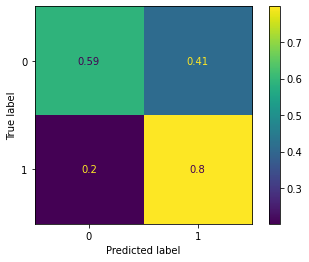

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, logr_preds, normalize='true')
plt.show()

In [ ]:
print(classification_report(y_test, logr_preds))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    273261
           1       0.06      0.80      0.10      8212

    accuracy                           0.60    281473
   macro avg       0.52      0.69      0.42    281473
weighted avg       0.96      0.60      0.72    281473



In [ ]:
accuracy_score(y_test, logr_preds)

0.5956024201255538

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, logr_preds)

0.6935724344285639

### Coefficient Analysis

In [ ]:
logr.coef_

array([[ 0.63503194, -2.07483677, -1.94184741, -1.30393222, -1.13780694,
        -0.79120874, -0.37338883,  0.21862368,  0.52575568,  0.88700533,
         1.06699258,  1.36351531,  1.61902435,  1.94229158,  0.4936674 ,
        -0.72862488,  0.06174698,  0.02093493,  0.24802708, -0.09556391]])

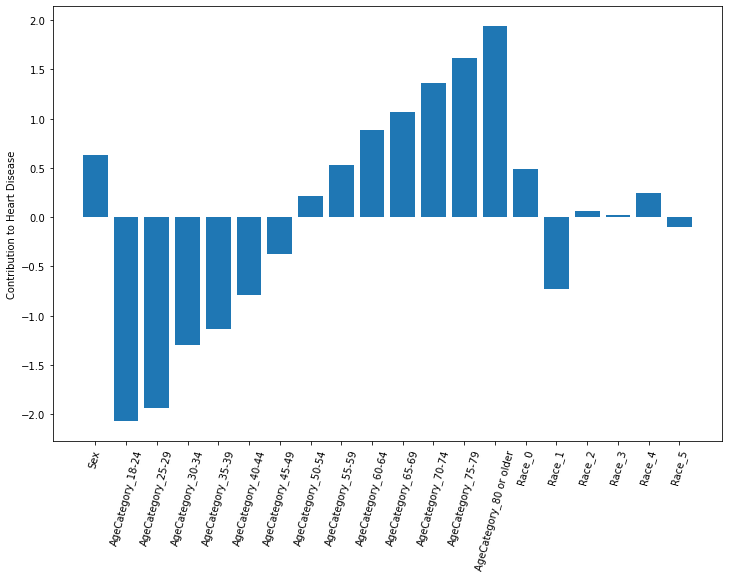

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(x=X_train.columns,
        height=logr.coef_[0])
plt.ylabel('Contribution to Heart Disease')
plt.xticks(rotation=75);

#**Nearest Neighbors Model**

### Scale the Data

In [ ]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)

### Fit the Model

In [ ]:
knn_params = {'n_neighbors': [2, 5, 10, 20, 30, 40, 50]}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, knn_params)

knn_grid_search.fit(X_train_scaled, y_train)

knn_preds = knn_grid_search.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


### Model Evaluation

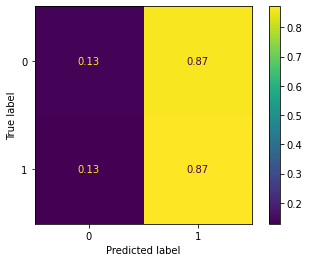

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, knn_preds, normalize='true')
plt.show()

In [ ]:
knn_grid_search.best_params_

{'n_neighbors': 50}

In [ ]:
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.97      0.13      0.24    273261
           1       0.03      0.87      0.06      8212

    accuracy                           0.16    281473
   macro avg       0.50      0.50      0.15    281473
weighted avg       0.94      0.16      0.23    281473



In [ ]:
accuracy_score(y_test, knn_preds)

0.15584798541956066

# **Decision Tree Model**

### Fit the Model

In [ ]:
dtc = DecisionTreeClassifier()

dtc_parms = {'max_depth': [2, 5, 10, 25, 50, 100],
             'min_samples_split': [2, 5, 10, 25, 50, 100],
             'min_samples_leaf': [2, 5, 10, 25, 50, 100]}

dtc_grid_search = GridSearchCV(dtc, dtc_parms)

dtc_grid_search.fit(X_train, y_train)

dtc_preds = dtc_grid_search.predict(X_test)

### Model Evaluation

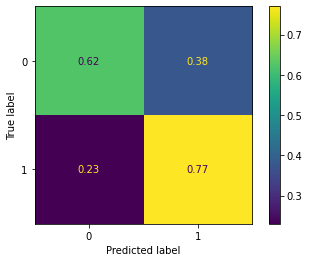

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, dtc_preds, normalize='true')
plt.show()

In [ ]:
dtc_grid_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [ ]:
print(classification_report(y_test, dtc_preds))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76    273261
           1       0.06      0.77      0.11      8212

    accuracy                           0.63    281473
   macro avg       0.52      0.70      0.44    281473
weighted avg       0.96      0.63      0.75    281473



In [ ]:
accuracy_score(y_test, dtc_preds)

0.627978527247729

# **Random Forest Classifier Model**

### Fit the Model

In [ ]:
rfc = RandomForestClassifier()

rfc_params = {'max_depth': [25, 50, 100],
             'min_samples_split': [ 25, 50, 100],
             'min_samples_leaf': [25, 50, 100],
             'n_estimators': [300, 350, 400]}

rfc_grid_search = GridSearchCV(rfc, rfc_params)

rfc_grid_search.fit(X_train, y_train)

rfc_grid_search_preds = rfc_grid_search.predict(X_test)

### Model Evaluation

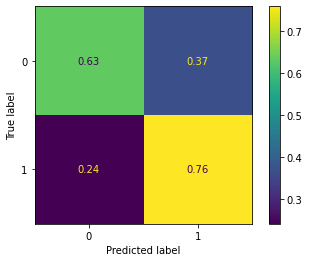

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, rfc_grid_search_preds, normalize='true')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score

print(accuracy_score(y_test, rfc_grid_search_preds))


0.6352083503568726


In [ ]:
rfc_grid_search.best_params_

{'max_depth': 50,
 'min_samples_leaf': 25,
 'min_samples_split': 100,
 'n_estimators': 350}

# **Gradient Boosting Classifier (Code is available, but takes a long time to run)**

### Fit the Model

In [ ]:
# gbc = GradientBoostingClassifier()

# gbc_params = {'max_depth': [2, 5, 10, 50],
#               'min_samples_split': [2, 5, 10, 25, 50],
#               'min_samples_leaf': [2, 5, 10, 25, 50],
#               'n_estimators': [50, 100, 150, 200, 250], 
#               'learning_rate': [0.05, 0.25, 0.5, 0.75, 1]}

# gbc_grid_search = GridSearchCV(gbc, gbc_params)

# gbc_grid_search.fit(X_train, y_train)

# gbc_grid_search_preds = gbc_grid_search.predict(X_test)

### Model Evaluation

In [ ]:
# gbc_grid_search.best_params_

In [ ]:
# ConfusionMatrixDisplay.from_predictions(y_test, gbc_grid_search_preds, normalize='true')
# plt.show()

# **Ensemble Model**

### Fit Model

In [ ]:
vote_clf = VotingClassifier([('logr', logr), ('dtc', dtc_grid_search.best_estimator_), ('rfc', rfc_grid_search.best_estimator_)])

vote_clf.fit(X_train, y_train)

vote_preds = vote_clf.predict(X_test)

### Model Evaluation

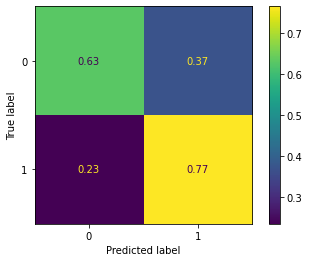

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, vote_preds, normalize='true')
plt.show()

In [ ]:
accuracy_score(y_test, vote_preds)

0.6331015763501295

In [ ]:
roc_auc_score(y_test, vote_preds)

0.6976488293461814